# Project Text Mining (Part 1) 

This notebook was made as the Text Mining Project for Master Data Mining of Université Lyon 2. 

## Objective:

The main goal is to pratice the concepts seen in class and apply text mining tecniques in a dataset. 

## Plan:

This notebook will be separated into the following sections

$\rightarrow$ Acquisition des données 

$\rightarrow$. Construction d’un index sur les mots

$\rightarrow$. Regrouper les documents par cluster et/ou thématique


**Owners**: Lia Furtado and Hugo Vinson 


---

In [1]:
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk 
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
import unicodedata
from collections import Counter
import string
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from yellowbrick.text import FreqDistVisualizer
import seaborn as sns
import math
import networkx as nx
from pyvis.network import Network
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from plotly.subplots import make_subplots
import plotly.express as px
from transformers import BertTokenizer, TFBertModel
from langdetect import detect
from sklearn.metrics import silhouette_score  
from sklearn.manifold import Isomap

---
## Acquisition des données

This part consists in loading the dataset from https://www.aminer.org/citation and creating a usable dataset with smaller size and better structure. 



In [2]:
#Loading the json dataset retrieved from the website 
data = []
with open('dblp-ref-0.json') as f:
    for line in f:
        data.append(json.loads(line))
        
df = pd.json_normalize(data)

#Get a small subset of data by filtering only the citations from 2016

data_2016 = df[(df['year'] == 2016)]

#Remove movies with abstract null
data_2016 = data_2016[~data_2016['abstract'].isnull()] 
#Reindex the dataframe
data_2016.reset_index(drop=True, inplace=True)
data = data_2016

In [3]:
data.head()

(11269, 8)

---
## Construction d’un index sur les mots


This section is to first preprocess the texts by removing stop-words, frequent words, rare words, perform stemming or lemmatization etc. Then to vizualize some common words and understand the data. Finally, to vectorize the words by performing TF-IDF, Doc2Vec and BERT transformations. 

This section is separated as follows:

* Text Cleaning and Data Pre-processing 
* Data Exploratory analysis (by visualization)
* Text Vectorization 


### Text Cleaning and Data Pre-processing 

In [4]:
#Joining the title and abstract text
data['text'] = data['title'] + ' ' + data['abstract']



In [5]:
#Loading the stopwords
stop_words = stopwords.words('english')
stopwords_en = set(stop_words)


In [6]:
def cleanup_authors(msg):
    #removing []
    sentence = re.sub(r"[\([{})\]]",r'', msg)
    #removing '' and .
    sentence = sentence.replace("'", "").replace(".", "") 
    sentence = sentence.replace("\\", "").replace("/", "") 
    sentence = sentence.replace('"','') 
    #remove all non latin caracters
    sentence = re.sub(r'[^\x00-\x7f]',r'', sentence)
    #removing digits
    sentence = re.sub("\S*\d+\S*", "", sentence)
    #remove diactric accents and greek letters
    sentence = ''.join(c for c in unicodedata.normalize('NFD', sentence)
                  if unicodedata.category(c) != 'Mn')
    #hyphen the authors
    sentence = list(sentence.split(", "))
    sentence = [word.lower().replace(' ','-') for word in sentence]
    return sentence

In [7]:
def cleanup_venue(msg):
    #removing pontuation
    No_Punctuation = [char if char not in string.punctuation else ' ' for char in msg ]
    sentence = ''.join(No_Punctuation)
    #removing []
    sentence = re.sub(r"[\([{})\]]",r'', msg)
    #removing '' and .
    sentence = sentence.replace(":", "") 
    sentence = sentence.replace(".", "")
    sentence = sentence.replace("\\", "").replace("/", "") 
    sentence = sentence.replace('"','') 
    sentence = sentence.replace("& ", "")
    sentence = sentence.replace("and ", "")
    #hyphen the authors
    sentence = list(sentence.split(", "))
    sentence = [word.lower().replace(' ','-') for word in sentence]
    return sentence

In [8]:
def cleanup_text(msg):
    #removing pontuation
    No_Punctuation = [char if char not in string.punctuation else ' ' for char in msg ]
    sentence = ''.join(No_Punctuation)
    #remove all non latin caracters
    sentence = re.sub(r'[^\x00-\x7f]',r'', sentence)
    #removing digits
    sentence = re.sub("\S*\d+\S*", "", sentence)
    #remove diactric accents and greek letters
    sentence = ''.join(c for c in unicodedata.normalize('NFD', sentence)
                  if unicodedata.category(c) != 'Mn')
    #### Word tokenization is the process of splitting up “sentences” into “words”
    sentence = nltk.word_tokenize(sentence)
    #Stemming the words
    #stemmer = PorterStemmer()
    return " ".join(word.lower() for word in sentence if word.lower() not in stopwords_en and len(word.lower())>1)


In [9]:
#Most 40 used words in bag of words
def clean_words(msg):
    erase_words = ['based','data', 'proposed', 'paper', 'model','method','results','time','algorithm','using','problem', \
                   'two', 'system','performance','approach','network','show','also','information','analysis','new', \
                   'used','systems', 'different','study','methods','networks','number','one','order','set','algorithms',\
                   'high','control','models','propose','learning','use','image','problems']
    
    return " ".join(char for char in word_tokenize(msg) if char not in erase_words)

In [10]:
data['text_clean'] = data['text'].apply(lambda x:cleanup_text(x))
data['text_clean'] = data['text_clean'].apply(lambda x:clean_words(x))

In [11]:
data['text_clean_tokenized'] = data['text_clean'].apply(lambda x:nltk.word_tokenize(x))
data = data[~data['venue'].isnull()] 
data.reset_index(inplace=True, drop=True)

In [12]:
data['authors_clean'] = data['authors'].apply(lambda x:cleanup_authors(str(x)))
data['venue_clean'] = data['venue'].apply(lambda x:cleanup_venue(x))

In [13]:
data = data.drop(labels=[149,4501,5141, 6854,7480,9187, 9207,10426], axis=0)
data.reset_index(inplace=True, drop=True)

In [14]:
data.head()

abstract  \
0  In this article, we show how to compute the wi...   
1  Traditional methods on video summarization are...   
2  Decision tree is an important method for both ...   
3  Full-reference image quality assessment (FR-IQ...   
4  The Fomin-Kirillov algebra E n is a noncommuta...   

                                             authors  n_citation  \
0                  [Alexandr Andoni, Huy L. Nguyêݱn]           0   
1  [Linbo Wang, Xianyong Fang, Yanwen Guo, Yanwei...           3   
2  [Singh Vijendra, Hem Jyotsana Parashar, Nisha ...           0   
3                [Ashirbani Saha, Q. M. Jonathan Wu]          50   
4                                    [Ricky Ini Liu]           1   

                                          references  \
0  [04d59cae-87b1-4706-9f5f-009ee3e94626, 228e075...   
1  [0f80ec27-572e-473b-a403-f0f7c47c4743, 18a8568...   
2  [6d903194-6be4-4780-9ccf-d60916e00770, 7396789...   
3  [02acc8f4-e6d9-4958-bd08-a1185631f22a, 108636d...   
4  [7ff3b6e7-35b3-4cca-af97-c39d38bdf080, d885dd2...   

                                               title  \
0             Width of Points in the Streaming Model   
1  Multi-view Metric Learning for Multi-view Vide...   
2  A New Method for Classification of Datasets fo...   
3  Full-reference image quality assessment by com...   
4  On the commutative quotient of Fomin-Kirillov ...   

                               venue  year  \
0   symposium on discrete algorithms  2016   
1                        cyberworlds  2016   
2                    arXiv: Learning  2016   
3                  Signal Processing  2016   
4  European Journal of Combinatorics  2016   

                                     id  \
0  2a68616f-ae27-46aa-8d7b-292a23e3291f   
1  348045c5-4d43-4c96-b106-e1038e5d4aaa   
2  82f3e31c-2139-42f9-88ab-2116621eb207   
3  0db3464c-7e35-4bb1-be09-f6f079258e0f   
4  221a3099-ae5a-4e38-b793-d27d1795313f   

                                                text  \
0  Width of Points in the Streaming Model In this...   
1  Multi-view Metric Learning for Multi-view Vide...   
2  A New Method for Classification of Datasets fo...   
3  Full-reference image quality assessment by com...   
4  On the commutative quotient of Fomin-Kirillov ...   

                                          text_clean  \
0  width points streaming article compute width d...   
1  multi view metric multi view video summarizati...   
2  classification datasets mining decision tree i...   
3  full reference quality assessment combining gl...   
4  commutative quotient fomin kirillov algebras f...   

                                text_clean_tokenized  \
0  [width, points, streaming, article, compute, w...   
1  [multi, view, metric, multi, view, video, summ...   
2  [classification, datasets, mining, decision, t...   
3  [full, reference, quality, assessment, combini...   
4  [commutative, quotient, fomin, kirillov, algeb...   

                                       authors_clean  \
0                     [alexandr-andoni, huy-l-nguyn]   
1  [linbo-wang, xianyong-fang, yanwen-guo, yanwei...   
2  [singh-vijendra, hem-jyotsana-parashar, nisha-...   
3                  [ashirbani-saha, q-m-jonathan-wu]   
4                                    [ricky-ini-liu]   

                           venue_clean  
0   [symposium-on-discrete-algorithms]  
1                        [cyberworlds]  
2                     [arxiv-learning]  
3                  [signal-processing]  
4  [european-journal-of-combinatorics]

In [15]:
data.to_csv('dblp_2016_cleaned.csv', index=False)

### Data Exploratory analysis (by visualization)

In [2]:
data = pd.read_csv('dblp_2016_cleaned.csv')

**Most Common words** 

In [17]:
docs = [[w.lower() for w in word_tokenize(text)] 
            for text in list(data['text_clean'])]
bag_of_words = [item for sublist in docs for item in sublist]

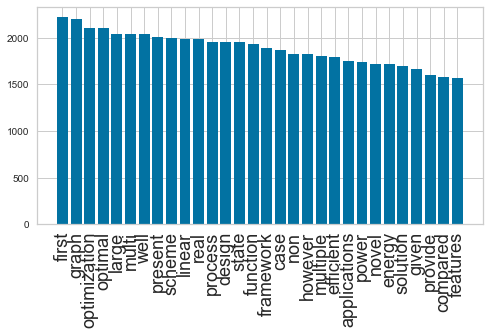

In [18]:
#TOP 30 MOST COMMON WORDS
x=[]
y=[]

counter = Counter(bag_of_words)
most = counter.most_common()

for word,count in most[:30]:
        x.append(word)
        y.append(count)
plt.figure(figsize=(8,4))
plt.xticks(fontsize=18, rotation=90)

plt.bar(x,y)
plt.show()

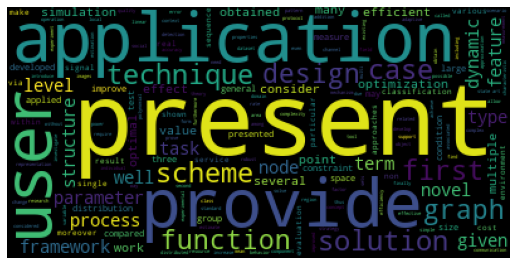

In [19]:
# Word Cloud
plt.figure(figsize=(9,18))
word_cloud = WordCloud(background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(bag_of_words))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()


**Most Common Authors and Venues** 

In [5]:
bag_of_authors = [item for sublist in data['authors_clean'] for item in sublist]

bag_of_venues = [item for sublist in data['venue_clean'] for item in sublist]

Text(0.5, 1.0, 'Top 10 Venues')

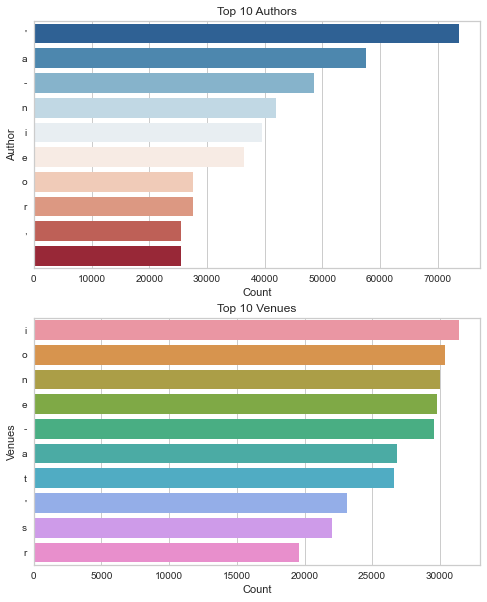

In [21]:
# Top 10 authors
plt.figure(figsize=(8, 10)) 

plt.subplot(2, 1, 1)

top10authors = pd.DataFrame.from_records(
    Counter(bag_of_authors).most_common(10), columns=["Author", "Count"]
)
sns.barplot(x="Count", y="Author", data=top10authors, palette="RdBu_r")
plt.title("Top 10 Authors")

plt.subplot(2, 1, 2)

# TOP 10 Venues
top10venues = pd.DataFrame.from_records(
    Counter(bag_of_venues).most_common(10),
    columns=["Venues", "Count"],
)

sns.barplot(x="Count", y="Venues", data=top10venues)
plt.title("Top 10 Venues")

**Network  Vizualization of the top 20 authors**

In [3]:
df_connections = data[['title', 'text_clean', 'text_clean_tokenized','authors_clean', 'venue_clean']]

In [6]:
top20authors = pd.DataFrame.from_records(
    Counter(bag_of_authors).most_common(20), columns=["Name", "Count"])

articles_20_common_authors = []
for index, connection in df_connections.iterrows():
    for author in list(top20authors['Name']):
        if (author in connection['authors_clean']):
            articles_20_common_authors.append(connection)
            
df_20 = pd.DataFrame(articles_20_common_authors)

In [8]:
df_20['authors_combination'] = df_20['authors_clean'].apply(lambda x: list(combinations(x[::-1], 2)))
df_20 = df_20.explode('authors_combination','venue_clean')

df_20 = df_20[~df_20['authors_combination'].isnull()] 
df_20.reset_index(inplace=True, drop=True)
df_20['From'], df_20['To'] = zip(*df_20.authors_combination)

df_graph = df_20[['From', 'To', 'title']]

MemoryError: 

In [ ]:
MG= nx.from_pandas_edgelist(df_graph, 'From', 'To', edge_attr=['title'], 
                                 create_using=nx.MultiGraph())

MG.edges(data=True)

In [ ]:
net = Network(height='650px', width='100%', font_color='black', notebook =True)
net.from_nx(MG)
net.show("example.html")

### Text Vectorization

$\rightarrow$ **Term Frequency Inverse Document Frequency Vectorizer**

$\rightarrow$ **Doc2Vec**

$\rightarrow$ **BERT**




**TFIDF**

In [9]:
vectorizer = TfidfVectorizer(min_df=2, max_df = 0.4)
vectors = vectorizer.fit_transform(data['text_clean'])
tfidf_vectors = vectors.todense()


In [10]:
print('Total number of documents parsed: {}'.format(len(tfidf_vectors)))
print('Size of TF-IDF vector embeddings: ', tfidf_vectors.shape[1])
print('Shape of TF-IDF vectors embeddings matrix: ', tfidf_vectors.shape)

Total number of documents parsed: 11261
Size of TF-IDF vector embeddings:  18793
Shape of TF-IDF vectors embeddings matrix:  (11261, 18793)


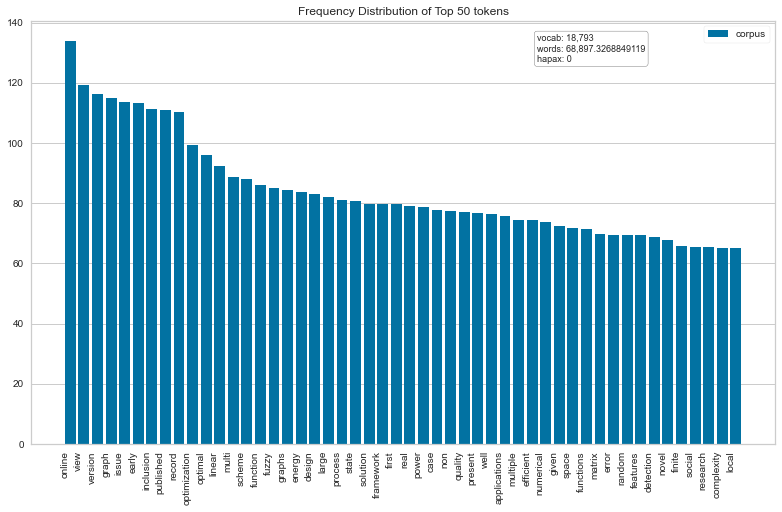

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [11]:
feature_names = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=feature_names, orient='v', size=(960, 560))
visualizer.fit(vectors)
visualizer.show()

**Doc2Vec**

In [12]:
tagged_docs = []

for i, list_tokens in enumerate(data['text_clean_tokenized']):
    tagged_docs.append(TaggedDocument(words=list_tokens, tags=[str(i+1)]))

In [13]:
print('Training Doc2Vec...')

d2v_model = Doc2Vec(vector_size=100, window=10, min_count=5, workers=11,alpha=0.025)
d2v_model.build_vocab(tagged_docs)
d2v_model.train(tagged_docs,total_examples=d2v_model.corpus_count, epochs=20)

Training Doc2Vec...


In [14]:
# Parse documents and print some info
print('Parsing documents...')

doc2vec_vectors = []

for index, list_tokens in enumerate(data['text_clean_tokenized']):
    doc2vec_vectors.append(d2v_model.dv[index])
        
doc2vec_vectors = np.array(doc2vec_vectors)

print('Total number of documents parsed: {}'.format(len(doc2vec_vectors)))
print('Size of Doc2Vec vector embeddings: ', doc2vec_vectors.shape[1])
print('Shape of Doc2Vec vectors embeddings matrix: ', doc2vec_vectors.shape)

Parsing documents...
Total number of documents parsed: 11261
Size of Doc2Vec vector embeddings:  100
Shape of Doc2Vec vectors embeddings matrix:  (11261, 100)


**BERT**

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")

def encode_bert(text):
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    bert_output = output.last_hidden_state.numpy()
    bert_data = np.apply_along_axis(lambda x: np.mean(x), 1, bert_output)
    
    return bert_data

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [16]:
if not os.path.exists('bert_vectors'):
    bert_vectors = []
    for i, text in enumerate(data['text_clean']):  
            bert_vectors.append(encode_bert(text))

    bert_vectors = np.array(bert_vectors)
    bert_vectors = np.reshape(bert_vectors, (bert_vectors.shape[0], bert_vectors.shape[2]))
    np.ndarray.dump(bert_vectors, open('bert_vectors', 'wb'))
else:
    bert_vectors = np.load(open('bert_vectors', 'rb'), allow_pickle=True)

In [17]:
print('Total number of documents parsed: {}'.format(len(bert_vectors)))
print('Size of Doc2Vec vector embeddings: ', bert_vectors.shape[1])
print('Shape of Doc2Vec vectors embeddings matrix: ', bert_vectors.shape)

Total number of documents parsed: 11261
Size of Doc2Vec vector embeddings:  768
Shape of Doc2Vec vectors embeddings matrix:  (11261, 768)


---
## Regrouper les documents par cluster et/ou thématique


This part consists of separating the texts into clusters and analyzing the different visualizations depending on the chosen vectorization model. We will test with TF-IDF, Doc2Vec and a pre-trained BERT model. 

In [18]:
values  = doc2vec_vectors
n_clusters = range(2,5)
for k in n_clusters:
    clusters = KMeans(n_clusters=k)
    print(clusters)
    prediction = clusters.fit_predict(values)

    score = silhouette_score(values, prediction)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

KMeans(n_clusters=2)
For n_clusters = range(2, 5), silhouette score is 0.11562179774045944)
KMeans(n_clusters=3)
For n_clusters = range(2, 5), silhouette score is 0.11657463014125824)
KMeans(n_clusters=4)
For n_clusters = range(2, 5), silhouette score is 0.09920833259820938)


In [19]:

k = 3
representations = {"TF-IDF" : np.asarray(tfidf_vectors), \
                    "Doc2Vec" : doc2vec_vectors, 
                    "BERT" : bert_vectors}

print('Clustering documents...')

results = []
for key, value in representations.items():
    print("Representation " + str(key))
    labels = KMeans(n_clusters=k, random_state=0).fit_predict(value)
    results.append({"Representation" : key, "labels" :list(labels)})
    
    silhouette_avg = silhouette_score(value, labels)
    print(
        "The average silhouette_score is :",
        silhouette_avg,
    )


Clustering documents...
Representation TF-IDF
The average silhouette_score is : 0.009904326302845618
Representation Doc2Vec
The average silhouette_score is : 0.11657463
Representation BERT
The average silhouette_score is : 0.10846714


**Clustering vizualization in each embedding**

In [20]:
fig = make_subplots(rows=3, cols=1, subplot_titles=("TF-IDF","Doc2Vec", "BERT"))
i = 1
for res in results:
    
    print('Isomap for ' + str(res['Representation']) +'...')

    embedding = Isomap(n_components=2)
    
    components = embedding.fit_transform(representations[res['Representation']])
    labels = res['labels']
    
    print('Plot for ' + str(res['Representation']))

    X = components[:, 0]
    y = components[:, 1]
    
    fig1 = px.scatter(X,y,color=labels)
    trace1 = fig1['data'][0]

    fig.add_trace(trace1, row=i, col=1)
    
    i = i + 1

fig.update_layout(height=1500, width=600, title_text="Embedding x Vizu")
fig.show()

Isomap for TF-IDF...
Plot for TF-IDF
Isomap for Doc2Vec...
Plot for Doc2Vec
Isomap for BERT...
Plot for BERT
